In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import agama

In [5]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 16})

In [2]:
# ----------------------------
# Parameters
# ----------------------------

# Number of particles
N = 200000

# Physical constants and parameters
M = 1.0              # Total mass of the Plummer sphere
R = 0.2              # Scale radius of the Plummer model
G = 1.0              # Gravitational constant (in units where G=1)

# Create the Plummer potential and density
pot_plummer_ini = agama.Potential(type='Plummer', mass=M, scaleradius=R)
den_plummer = agama.Density(type='Plummer', mass=M, scaleradius=R)

# Create the Distribution Function 
df = agama.DistributionFunction(
    type='QuasiSpherical',
    potential=pot_plummer_ini,
    density=den_plummer
)

# Create the AGAMA GalaxyModel for the Chosen Potential
model = agama.GalaxyModel(potential=pot_plummer_ini, df=df)

# Sample Initial Conditions
print("Sampling initial conditions...")
Nlarge = int(10*N)  # Sample a larger number for better statistics
samples_large, masses_large = model.sample(Nlarge)
# Randomly select N particles from the sampled data
indices = np.random.choice(Nlarge, size=N, replace=False)
samples = samples_large[indices]
print("Finished sampling.")

# Extract positions and velocities
positions_ini = samples[:, :3]    # Shape: (N, 3)
velocities_ini = samples[:, 3:]   # Shape: (N, 3)

Sampling initial conditions...
Finished sampling.


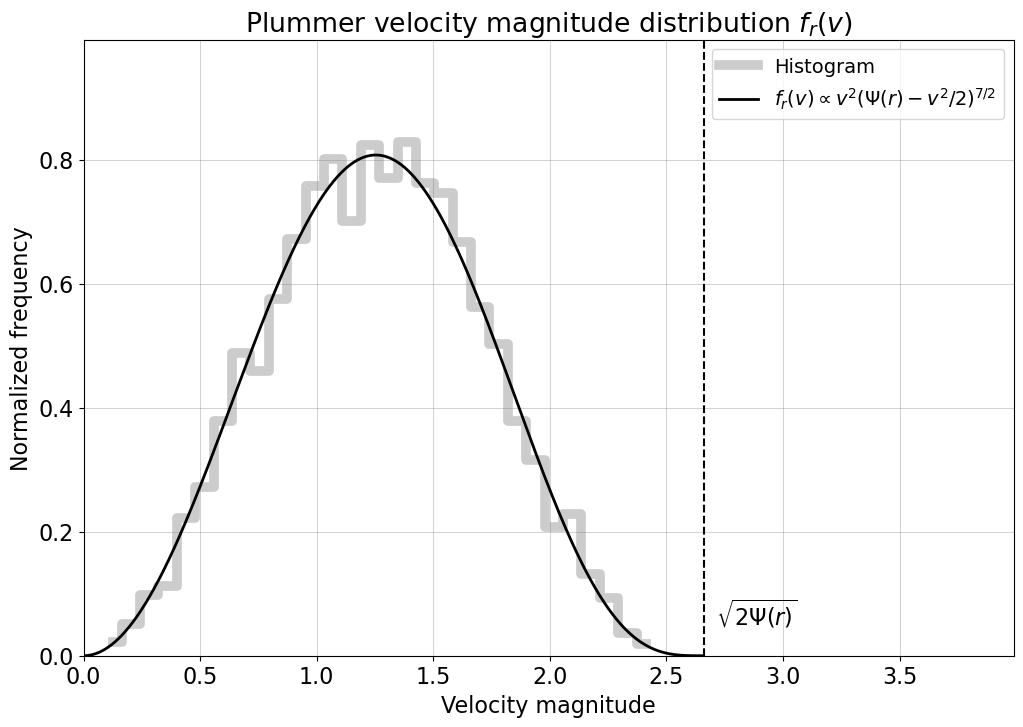

In [47]:
# Define fixed radius and shell width
r_fixed = 0.2  # Fixed radius
dr = 0.01       # Shell width
bins = 30  # Number of bins for velocity histogram

# Define the theoretical velocity distribution function
def theoretical_velocity_distribution(v, r_fixed, M, R, G, norm_factor=1):
    # Gravitational potential at r_fixed (Plummer potential)
    Psi_r = G * M / np.sqrt(r_fixed**2 + R**2)
    # Energy per unit mass at r_fixed
    E = Psi_r - 0.5 * v**2
    # Only include velocities with positive energy (bound particles)
    f_v = np.zeros_like(v)
    mask = E > 0
    f_v[mask] = norm_factor * v[mask]**2 * E[mask]**(7/2) 
    return f_v
    
# Compute radial distances from positions
radial_distances = np.sqrt(np.sum(positions_ini**2, axis=1))

# Select particles within the shell [r_fixed, r_fixed + dr]
mask = (radial_distances >= r_fixed) & (radial_distances < r_fixed + dr)

# Compute velocity magnitudes for particles within the shell
velocities_magnitudes = np.sqrt(np.sum(velocities_ini[mask]**2, axis=1))

# Compute the histogram
hist_values, bin_edges = np.histogram(velocities_magnitudes, bins=bins, density=True)

# Compute the midpoints of the bins for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate velocity values for theoretical curve
v_vals = np.linspace(0, np.sqrt(2 * G * M / np.sqrt(r_fixed**2 + R**2)), 1000)
theoretical_dist = theoretical_velocity_distribution(v_vals, r_fixed, M, R, G)

# Normalize the theoretical curve to match the histogram
theoretical_dist /= np.trapz(theoretical_dist, v_vals)  # Normalize to unit area

# Plot the histogram
plt.figure(figsize=(12, 8))
plt.plot(bin_centers, hist_values, drawstyle='steps-mid', label='Histogram', lw='7', 
         color='grey', alpha=0.4)
plt.plot(v_vals, theoretical_dist, color='black', lw=2, 
         label='$f_r(v)\propto v^2(\Psi(r)-v^2/2)^{7/2}$')

plt.legend(fontsize=14)
plt.xlim(0, 1.5*v_vals.max())
plt.ylim(0, 1.2*hist_values.max())

plt.vlines(v_vals.max(), 0, 1.2*hist_values.max(), color='black', linestyle='--')
plt.text(v_vals.max()+0.02*v_vals.max(), 0.05, r'$\sqrt{2\Psi(r)}$', fontsize=16, color="black")

plt.title(f"Plummer velocity magnitude distribution $f_r(v)$")
plt.xlabel("Velocity magnitude")
plt.ylabel("Normalized frequency")
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

plt.savefig("../Figures/plummer_df_histo.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()


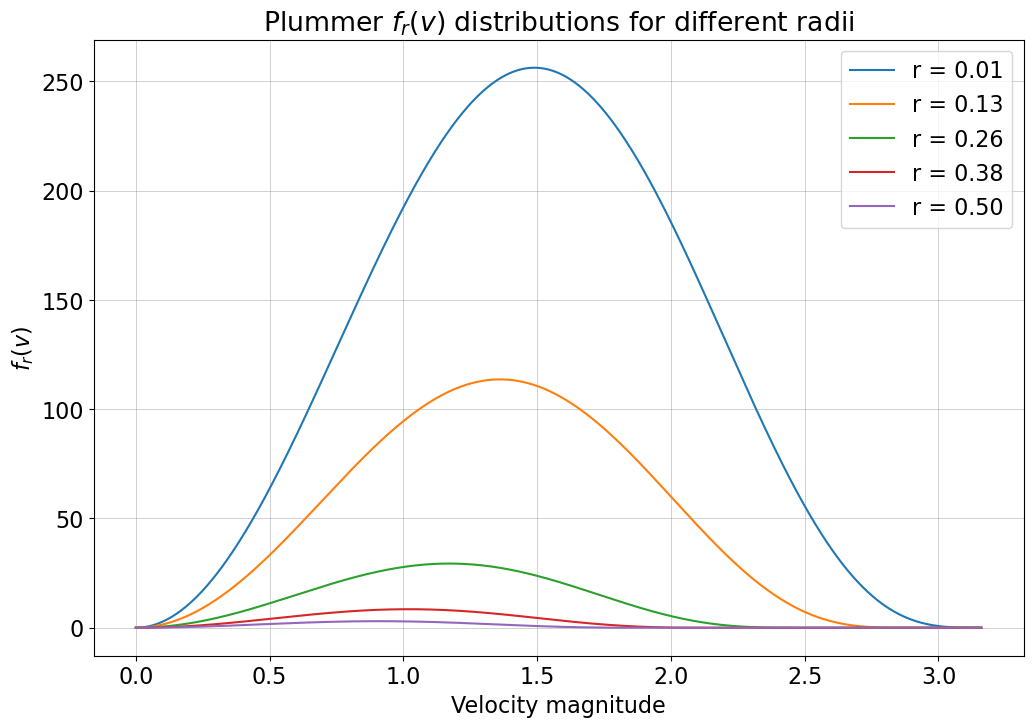

In [46]:
# Array of radii
radii = np.linspace(0.01, 0.5, 5)  # Example array of radii

# Compute the maximum velocity as the escape velocity at the smallest radius
v_max = np.sqrt(2 * G * M / np.sqrt(np.min(radii)**2 + R**2))
v_vals = np.linspace(0, v_max, 1000)  # Velocity array

# Plot the theoretical velocity distribution for different radii
plt.figure(figsize=(12, 8))
for r in radii:
    theoretical_dist = theoretical_velocity_distribution(v_vals, r, M, R, G)
    plt.plot(v_vals, theoretical_dist, label=f"r = {r:.2f}")

plt.title(r"Plummer $f_r(v)$ distributions for different radii")
plt.xlabel("Velocity magnitude")
plt.ylabel("$f_r(v)$")
plt.legend()
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

plt.savefig("../Figures/plummer_df_rs.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()